Data Processing Notebook
===

Prepare data for the analysis. The raw data is downloaded from the FAIR Universe HiggsML challenge repository. Use the HiggsML package to download and process the dataset, followed by selections and saving to local cache.



In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import yaml
from utils import plot_kinematic_features

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from HiggsML.systematics import systematics
hep.style.use(hep.style.ATLAS)

from HiggsML.datasets import download_dataset

In [33]:
data = download_dataset("https://zenodo.org/records/15131565/files/FAIR_Universe_HiggsML_data.zip")

2025-06-06 09:10:17,014 - HiggsML.datasets     - INFO     - Handling as URL: https://zenodo.org/records/15131565/files/FAIR_Universe_HiggsML_data.zip
2025-06-06 09:10:17,016 - HiggsML.datasets     - INFO     - Current working directory: /data/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau
2025-06-06 09:10:17,023 - HiggsML.datasets     - INFO     - Total rows: 220099101
2025-06-06 09:10:17,023 - HiggsML.datasets     - INFO     - Test size: 66029730


In [34]:
with open("config.yml", "r") as f:
    config = yaml.safe_load(f)

In [35]:
# path prefix for saving cached data used between modules
path_prefix = config['path_prefix']
path_saved_data = config['path_saved_data']

# Path for saving interemdiate objects, like NN predictions
saved_data = f'{path_prefix}{path_saved_data}'

if not os.path.exists(saved_data):
    print(f"Making new directory for caching data {saved_data}")
    os.makedirs(saved_data)


# Get the dictionary that assigns an integer with each of the processes
labels_dict = config["labels_dict"]
print(labels_dict)

{'htautau': 0, 'ztautau': 1, 'ttbar': 2}


In [12]:
list_of_processes = list(labels_dict.keys())

In [13]:
data.load_train_set(train_size=0.05)
df_training = data.get_train_set()
del data

2025-06-06 08:23:48,393 - HiggsML.datasets     - INFO     - Selected train size: 7703468
2025-06-06 08:26:19,287 - HiggsML.datasets     - INFO     - Data loaded successfully


In [14]:
df_training['type'] = df_training['detailed_labels'].copy()

df_training['has_jets'] = np.where(
    df_training['PRI_n_jets'] > 0, 1, 0
)

In [15]:
mask_selected_processes = np.isin(df_training.detailed_labels.to_numpy(), list_of_processes)
df_training = df_training[mask_selected_processes].copy()

In [16]:
df_training.detailed_labels.unique()

array(['ztautau', 'htautau', 'ttbar'], dtype=object)

In [17]:
df_training['train_labels'] = -1 

for key in labels_dict:
    df_training.loc[df_training['detailed_labels'] == key, 'train_labels'] = labels_dict[key]


In [18]:
df_training.columns.unique()

Index(['PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_had_pt', 'PRI_had_eta',
       'PRI_had_phi', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta',
       'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_n_jets',
       'PRI_jet_all_pt', 'PRI_met', 'PRI_met_phi', 'weights',
       'detailed_labels', 'labels', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_had_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_had', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'type', 'has_jets', 'train_labels'],
      dtype='object')

In [20]:
syst_settings = {
    'TES_up': {'tes': 1.02},
    'TES_dn': {'tes': 0.98},
    'JES_up': {'jes': 1.02},
    'JES_dn': {'jes': 0.98}
}

dataset_dict = {}

dataset_dict['nominal'] = systematics(
        data_set = df_training,
        dopostprocess=True
        )

for sample_name, syst_args in syst_settings.items():
    dataset_dict[sample_name] = systematics(
        data_set = df_training, 
        dopostprocess=True, 
        **syst_args
    )

del df_training


Selections
-

Preselect the dataset to remove phase space regions with low statistics

In [22]:
for sample in dataset_dict:
    
    mask_selection = (dataset_dict[sample]['PRI_lep_pt']<=200.0) & (dataset_dict[sample]['PRI_met']<=250.0) & (dataset_dict[sample]['PRI_had_pt']<=225.0) & (dataset_dict[sample]['PRI_jet_all_pt']<=500.0)
    dataset_dict[sample] = dataset_dict[sample][mask_selection].copy()

In [23]:
# Select the subset of features to keep in the saved dataset - remove unnecessary data
input_features = ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi', 'PRI_jet_all_pt', 'PRI_jet_leading_eta', 'PRI_n_jets', 'has_jets']
columns_to_keep = input_features + ['weights', 'detailed_labels', 'type', 'train_labels']

for sample in dataset_dict:
    dataset_dict[sample] = dataset_dict[sample][columns_to_keep].copy()

In [37]:
# Save the datasets for training and inference
for sample in dataset_dict: 
    dataset_dict[sample].to_hdf(f"{saved_data}df_{sample}.h5", key="dataset", mode="w")

Visualize the data
-

Check for low-stats phase space and effect from systematics before moving to the density ratio training.

In [26]:
import sys, importlib
importlib.reload(sys.modules['utils'])
from utils import plot_kinematic_features

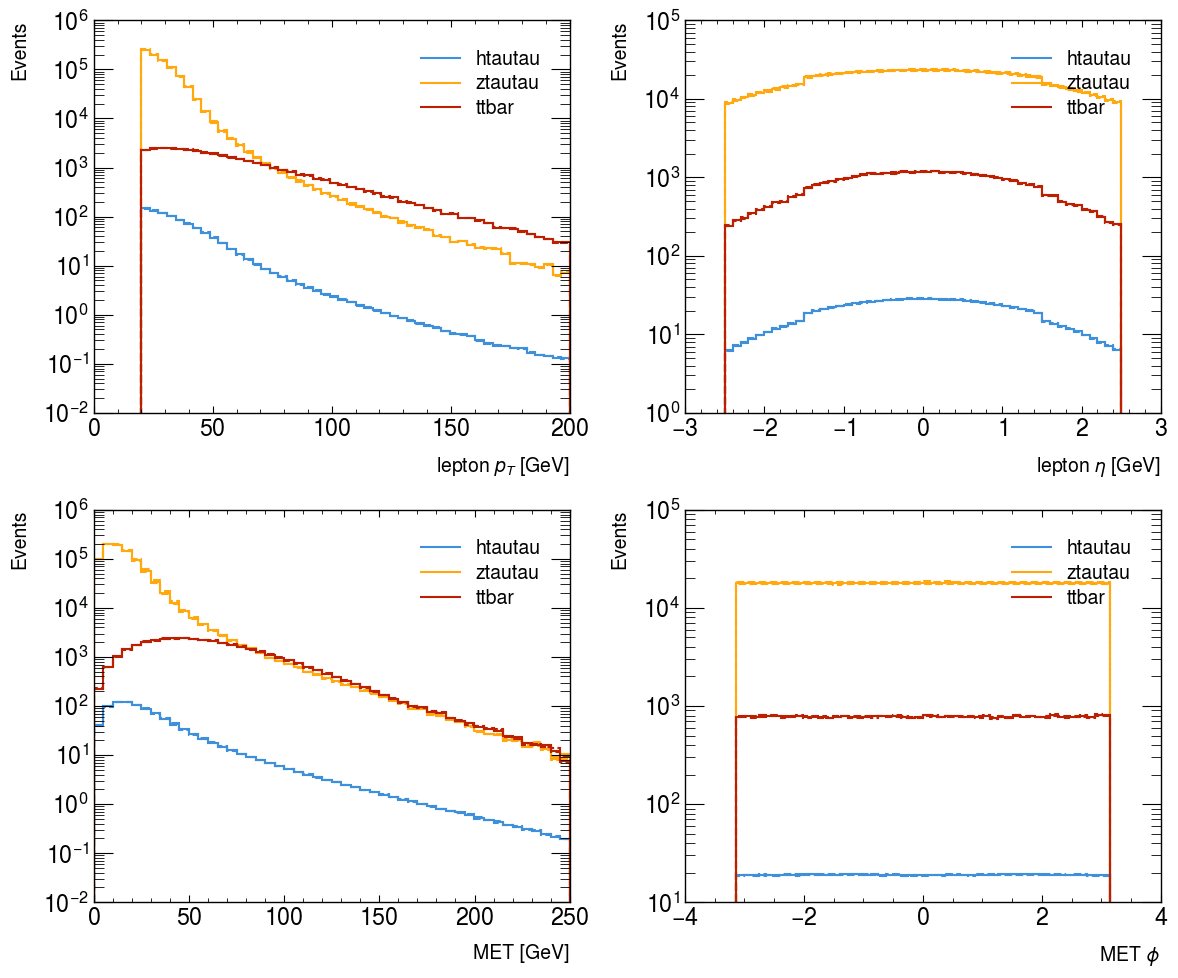

In [27]:
columns = ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_met', 'PRI_met_phi']
nbins = 50

xlabel_dict = {
    'PRI_lep_pt': 'lepton $p_T$ [GeV]', 
    'PRI_lep_eta': 'lepton $\\eta$ [GeV]', 
    'PRI_met': 'MET [GeV]', 
    'PRI_met_phi': 'MET $\\phi$',     
    'PRI_n_jets': '$n_{jets}$'      
}

variations_to_plot = ['nominal', 'TES_up', 'TES_dn']


fig, axes = plot_kinematic_features(
    columns=columns,
    nbins=nbins,
    variations_to_plot=variations_to_plot,
    dataset_dict=dataset_dict,
    xlabel_dict=xlabel_dict,
    labels_dict=labels_dict
)
plt.show()


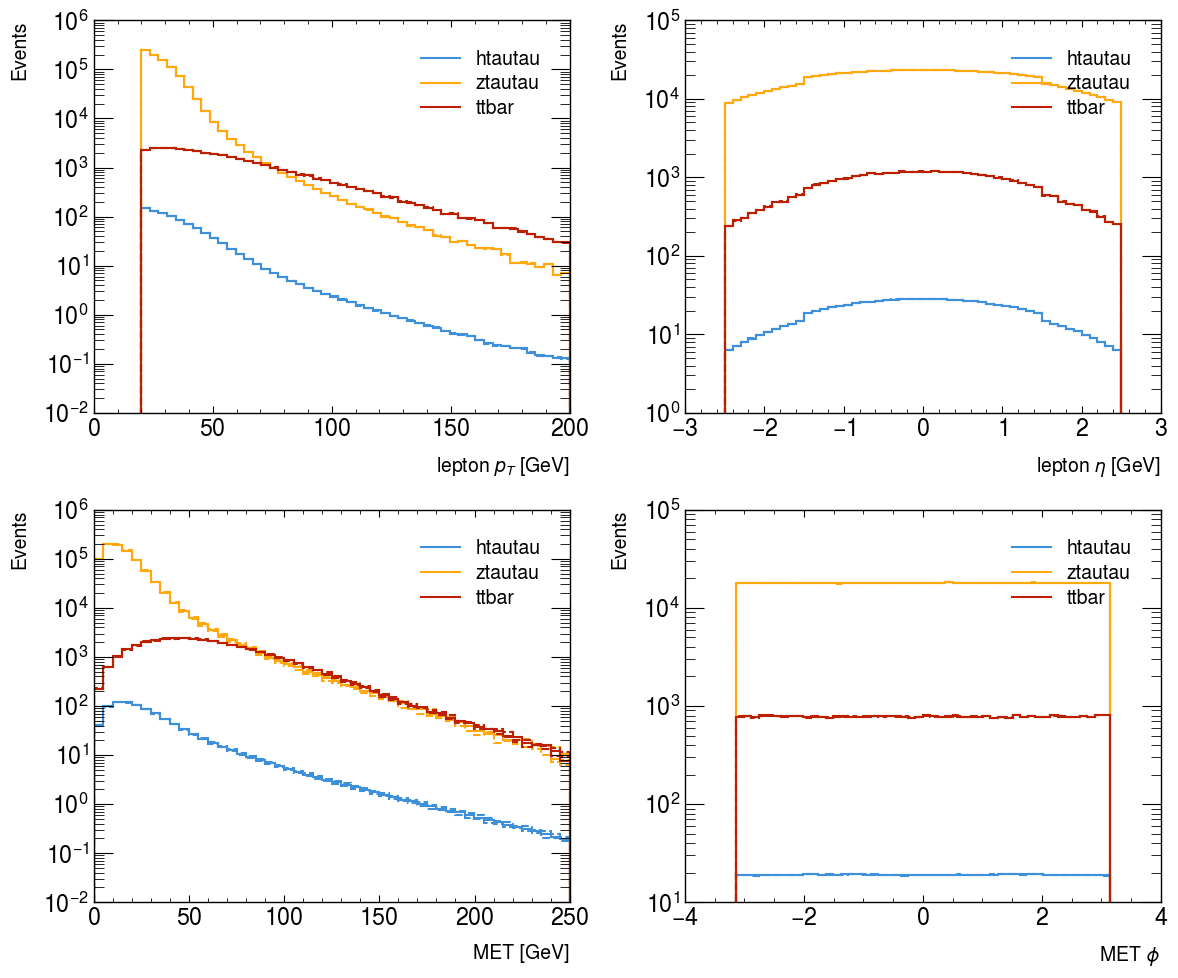

In [28]:
columns = ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_met', 'PRI_met_phi']
nbins = 50

xlabel_dict = {
    'PRI_lep_pt': 'lepton $p_T$ [GeV]', 
    'PRI_lep_eta': 'lepton $\\eta$ [GeV]', 
    'PRI_met': 'MET [GeV]', 
    'PRI_met_phi': 'MET $\\phi$',     
    'PRI_n_jets': '$n_{jets}$'      
}

variations_to_plot = ['nominal', 'JES_up', 'JES_dn']


fig, axes = plot_kinematic_features(
    columns=columns,
    nbins=nbins,
    variations_to_plot=variations_to_plot,
    dataset_dict=dataset_dict,
    xlabel_dict=xlabel_dict,
    labels_dict=labels_dict
)
plt.show()

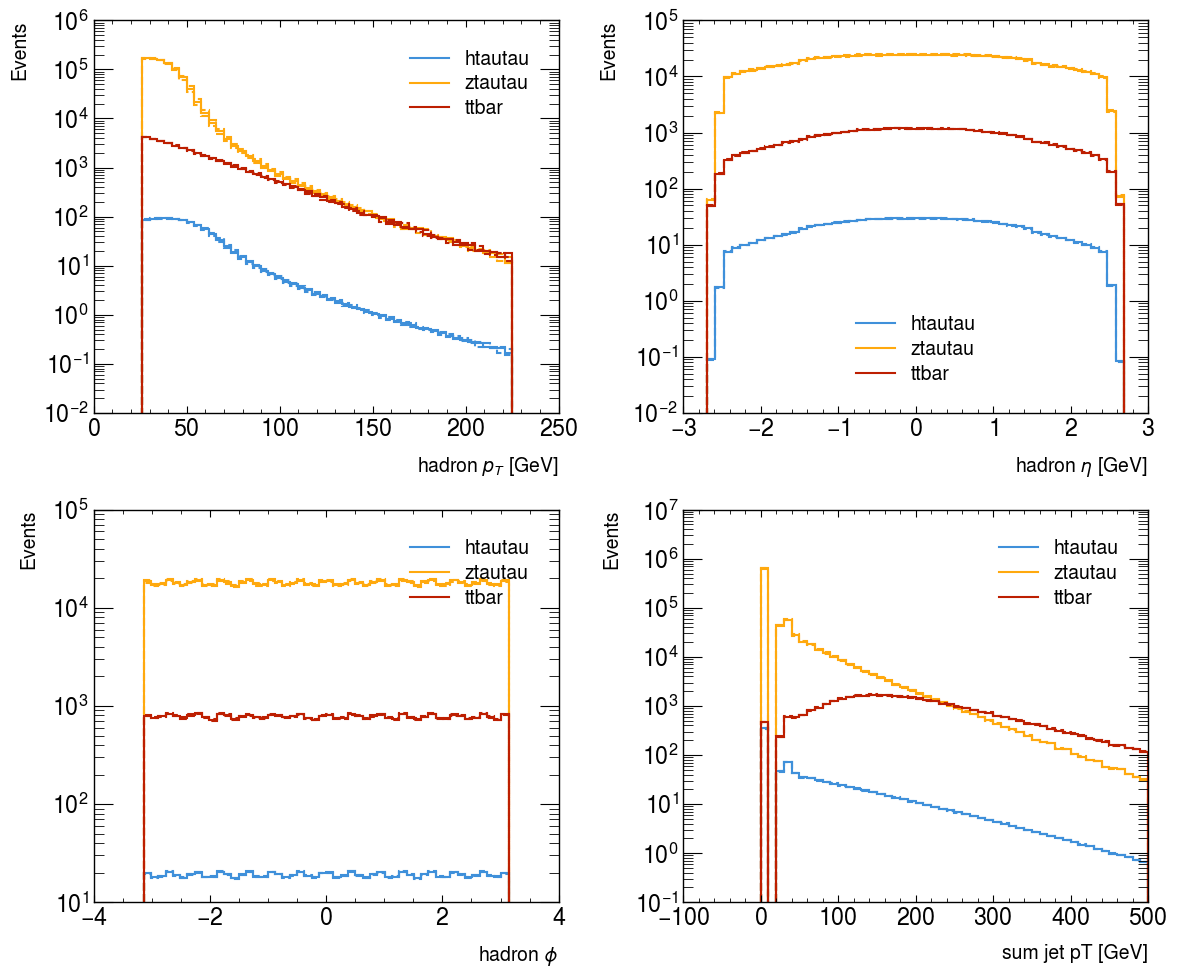

In [29]:
columns = ['PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi', 'PRI_jet_all_pt']
# columns = ['PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi']
nbins = 50

xlabel_dict = {
    'PRI_had_pt': 'hadron $p_T$ [GeV]', 
    'PRI_had_eta': 'hadron $\eta$ [GeV]', 
    'PRI_had_phi': 'hadron $\phi$', 
    'PRI_jet_all_pt': 'sum jet pT [GeV]',
}

variations_to_plot = ['nominal', 'TES_up', 'TES_dn']

fig, axes = plot_kinematic_features(
    columns=columns,
    nbins=nbins,
    variations_to_plot=variations_to_plot,
    dataset_dict=dataset_dict,
    xlabel_dict=xlabel_dict,
    labels_dict=labels_dict
)
plt.show()

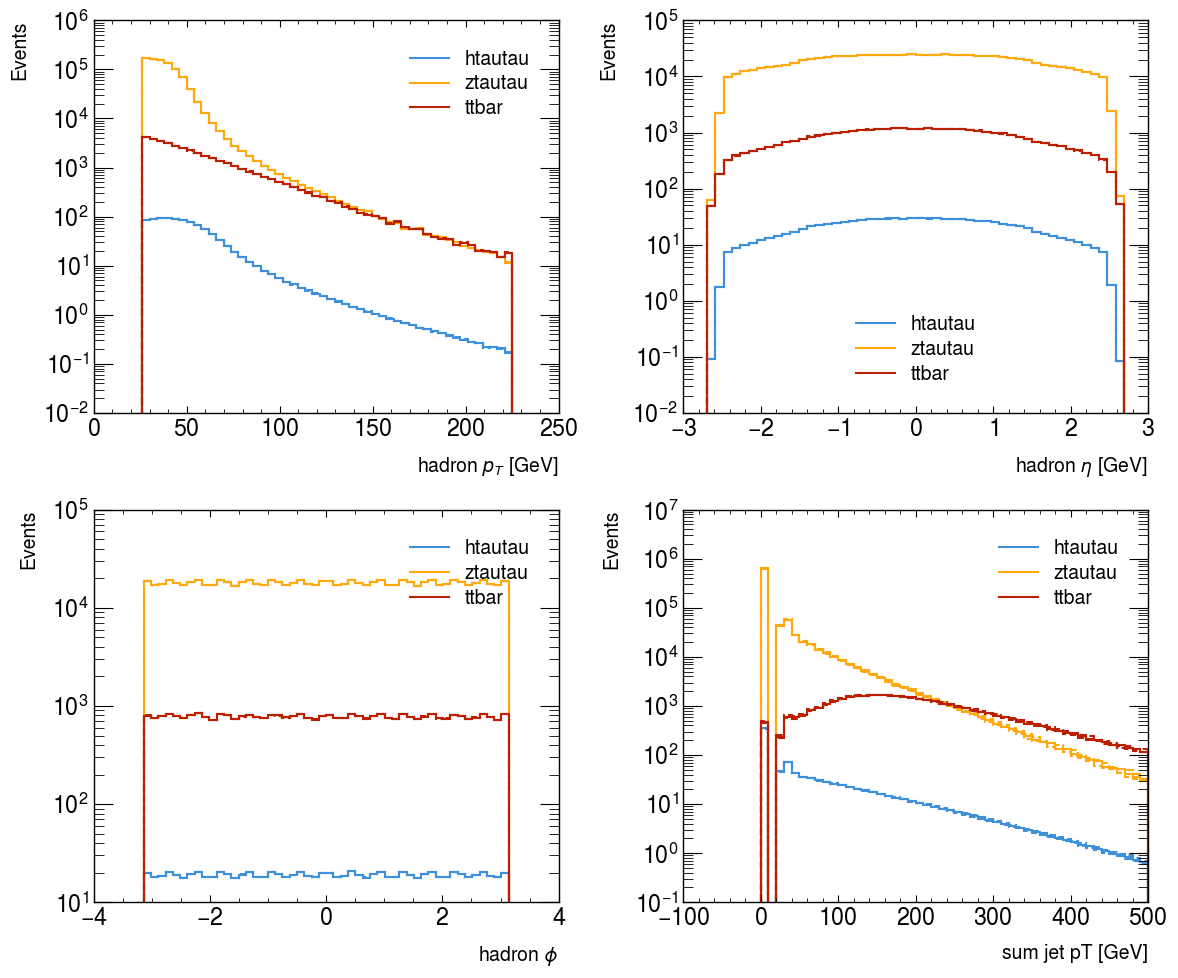

In [30]:
columns = ['PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi', 'PRI_jet_all_pt']
# columns = ['PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi']
nbins = 50

xlabel_dict = {
    'PRI_had_pt': 'hadron $p_T$ [GeV]', 
    'PRI_had_eta': 'hadron $\eta$ [GeV]', 
    'PRI_had_phi': 'hadron $\phi$', 
    'PRI_jet_all_pt': 'sum jet pT [GeV]',
}

variations_to_plot = ['nominal', 'JES_up', 'JES_dn']

fig, axes = plot_kinematic_features(
    columns=columns,
    nbins=nbins,
    variations_to_plot=variations_to_plot,
    dataset_dict=dataset_dict,
    xlabel_dict=xlabel_dict,
    labels_dict=labels_dict
)
plt.show()